In [1]:
import spacy
import en_core_web_lg
import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import numpy as np 
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import  Counter
import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will 

In [2]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.3
en_core_web_lg:	3.0.0
NLTK:	3.4.4
gensim:	3.8.3


In [3]:
def clean(text):
    return str(''.join([i if ord(i) < 128 else ' ' for i in text]))

In [4]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

In [5]:
text = open(lee_train_file).read()
nlp = en_core_web_lg.load()
stop_words = stopwords.words('english')
# text

In [6]:
for stop_word in stop_words:
    lex = nlp.vocab[stop_word]
    lex.is_stop = True

In [7]:
doc = nlp(clean(text))

In [8]:
texts, article = [], []
for w in doc:
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        article.append(w.lemma_)
    if w.text == '\n':
        texts.append(article)
        article = []

len(article), len(texts)

(142, 299)

In [9]:
transformed_texts_0 = [' '.join(i) for i in texts]
transformed_texts_1 = [i.lower() for i in transformed_texts_0]
transformed_texts_2 = [re.sub(r'\w*\d\w*', '', i).strip() for i in transformed_texts_1]
transformed_texts = transformed_texts_2

In [10]:
doc = nlp(" ".join([x for x in transformed_texts]))
n_adj = 0
adjs = {}
for token in doc:
    if token.pos_ == 'ADJ':
        if token.text not in adjs.keys():
            n_adj += 1
        adjs[token.text] = n_adj
    # print(f'{token.text:20} {token.pos_:10} {spacy.explain(token.tag_)}')
print(n_adj)

989


In [11]:
n_adj = 0
adjs = {}
for token in doc:
    if token.pos_ == 'ADJ':
        if token.text not in adjs.keys():
            n_adj += 1
        adjs[token.text] = n_adj
print(n_adj)

989


In [12]:
### ENTITIES
doc = nlp(" ".join([x for x in transformed_texts_2]))
entities = doc.ents

n = 0
ent_list = list()

for token in entities:
    if token.text not in ent_list:
        ent_list.append(token.text)
        n += 1

print(n)

495


In [13]:
def IDF(corpus, unique_words):
    idf_dic = {}
    N = len(corpus)
    for i in unique_words:
        count = 0
        for sent in corpus:
            if i in sent.split():
                count += 1
            idf_dic[i] = (math.log((N+1) / (count+1))) + 1
    return idf_dic

In [14]:
def fit(data):
    unique_words = set()
    if isinstance(data, (list, )):
        for x in data:
            for y in x.split():
                if len(y) < 2:
                    continue
                unique_words.add(y)
        unique_words = sorted(list(unique_words))
        vocab = { k:v for v,k in enumerate(unique_words) }
        idf_values = IDF(corpus=data, unique_words=unique_words)
    return (vocab, idf_values)
    

In [15]:
def transform(dataset, vocab, idf_values):
    vocab = {}
    lengths = (len(dataset), len(vocab))
    sparse_mat = csr_matrix(lengths, dtype=np.float64)
    for row in range(len(dataset)):
        n_words_in_sent = Counter(dataset[row].split()) 
        for word in dataset[row].split():
            if word in list(vocab.keys()):
                tf_idf_value =\
                    (n_words_in_sent[word] / len(dataset[row].split())) * (idf_values[word])
                sparse_mat[row, vocab] = tf_idf_value
                vocab[word] = tf_idf_value
    return vocab

In [16]:
### TF-IDF
vocab, idf = fit(transformed_texts)
# print(vocab)

In [17]:
sorted_idf = dict(sorted(idf.items(), key=operator.itemgetter(1), reverse=True))
# sorted_idf

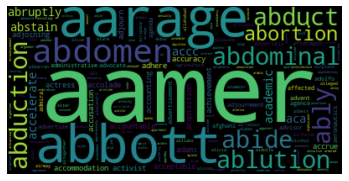

In [18]:
wordcloud = WordCloud().generate_from_frequencies(idf)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

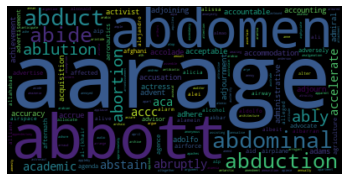

In [19]:
stop_words.extend(['aamer'])
stop_words_dic = Counter(stop_words)
transformed_texts_3 = [' '.join([word for word in i.split() if word not in stop_words_dic]) for i in transformed_texts]

vocab, idf = fit(transformed_texts_3)
sorted_idf = dict(sorted(idf.items(), key=operator.itemgetter(1), reverse=True))
wordcloud = WordCloud().generate_from_frequencies(idf)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

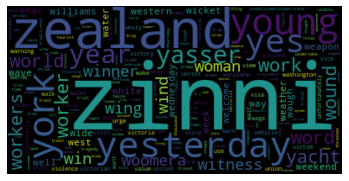

In [20]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=5, encoding='latin-1', ngram_range=(1,1), stop_words=stop_words)
features = tfidf.fit_transform(transformed_texts_3)
d = tfidf.vocabulary_

wordcloud = WordCloud().generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
sid = SentimentIntensityAnalyzer()
for i in range(len(transformed_texts_3)):
    # print(transformed_texts_3[i])
    print(sid.polarity_scores(transformed_texts_3[i])) 


{'neg': 0.135, 'neu': 0.753, 'pos': 0.111, 'compound': -0.5267}
{'neg': 0.311, 'neu': 0.644, 'pos': 0.045, 'compound': -0.9821}
{'neg': 0.337, 'neu': 0.542, 'pos': 0.12, 'compound': -0.9153}
{'neg': 0.26, 'neu': 0.617, 'pos': 0.123, 'compound': -0.9274}
{'neg': 0.201, 'neu': 0.732, 'pos': 0.067, 'compound': -0.8625}
{'neg': 0.078, 'neu': 0.844, 'pos': 0.077, 'compound': -0.2732}
{'neg': 0.061, 'neu': 0.689, 'pos': 0.25, 'compound': 0.9914}
{'neg': 0.185, 'neu': 0.716, 'pos': 0.1, 'compound': -0.3612}
{'neg': 0.232, 'neu': 0.624, 'pos': 0.143, 'compound': -0.9531}
{'neg': 0.092, 'neu': 0.795, 'pos': 0.114, 'compound': 0.4215}
{'neg': 0.133, 'neu': 0.728, 'pos': 0.139, 'compound': 0.1531}
{'neg': 0.38, 'neu': 0.573, 'pos': 0.047, 'compound': -0.9887}
{'neg': 0.217, 'neu': 0.568, 'pos': 0.215, 'compound': -0.6486}
{'neg': 0.124, 'neu': 0.568, 'pos': 0.309, 'compound': 0.9423}
{'neg': 0.465, 'neu': 0.535, 'pos': 0.0, 'compound': -0.9956}
{'neg': 0.215, 'neu': 0.74, 'pos': 0.046, 'compound'

In [22]:
### TOPIC MODELLING
# print(texts)
bigram = gensim.models.Phrases(texts)
gtexts = [bigram[line] for line in texts]
# print(gtexts)
dictionary = Dictionary(gtexts)
corpus = [dictionary.doc2bow(text) for text in gtexts]
# print(corpus)

In [23]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsimodel.show_topics(num_topics=5)

[(0,
  '0.788*"say" + 0.142*"Mr" + 0.095*"force" + 0.094*"israeli" + 0.094*"people" + 0.083*"Australia" + 0.082*"kill" + 0.080*"attack" + 0.079*"palestinian" + 0.079*"official"'),
 (1,
  '0.387*"israeli" + 0.345*"palestinian" + 0.286*"Mr_Arafat" + 0.192*"Israel" + 0.177*"official" + -0.164*"say" + 0.164*"Hamas" + 0.155*"kill" + 0.151*"West_Bank" + 0.136*"attack"'),
 (2,
  '-0.314*"Afghanistan" + -0.294*"force" + -0.218*"Al_Qaeda" + -0.195*"bin_Laden" + -0.159*"fighter" + -0.154*"Taliban" + -0.153*"Tora_Bora" + -0.151*"Pakistan" + -0.141*"afghan" + 0.115*"fire"'),
 (3,
  '0.403*"fire" + 0.290*"area" + 0.245*"Sydney" + 0.193*"firefighter" + 0.177*"north" + 0.167*"New_South" + 0.167*"Wales" + 0.167*"wind" + 0.141*"south" + 0.128*"line"'),
 (4,
  '-0.240*"Australia" + -0.235*"test" + 0.226*"Mr" + -0.223*"day" + -0.195*"match" + -0.186*"South_Africa" + -0.186*"wicket" + -0.167*"good" + -0.155*"play" + -0.147*"run"')]

In [24]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel.show_topics(num_topics=5)

[(4,
  '0.013*"say" + 0.004*"fire" + 0.004*"day" + 0.004*"Australia" + 0.004*"force" + 0.004*"wicket" + 0.003*"Wales" + 0.003*"north" + 0.003*"Australian" + 0.003*"new"'),
 (5,
  '0.022*"say" + 0.007*"Mr" + 0.006*"report" + 0.005*"force" + 0.005*"official" + 0.005*"Australia" + 0.004*"palestinian" + 0.004*"israeli" + 0.004*"Afghanistan" + 0.003*"man"'),
 (0,
  '0.031*"say" + 0.005*"bin_Laden" + 0.004*"Mr" + 0.004*"Australia" + 0.004*"force" + 0.004*"Al_Qaeda" + 0.004*"day" + 0.004*"Afghanistan" + 0.004*"fire" + 0.004*"United_States"'),
 (6,
  '0.035*"say" + 0.009*"people" + 0.005*"Mr" + 0.004*"israeli" + 0.004*"arrest" + 0.004*"Australia" + 0.003*"tell" + 0.003*"day" + 0.003*"come" + 0.003*"force"'),
 (8,
  '0.022*"say" + 0.007*"Mr" + 0.005*"Australia" + 0.005*"company" + 0.004*"day" + 0.004*"people" + 0.003*"israeli" + 0.003*"Pakistan" + 0.003*"new" + 0.003*"kill"')]

In [25]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

[(0,
  '0.010*say + 0.003*kill + 0.003*Australia + 0.003*people + 0.003*airport + 0.003*President + 0.002*Taliban + 0.002*match + 0.002*near + 0.002*night + 0.002*force + 0.002*military + 0.002*half + 0.002*day + 0.002*Interlaken + 0.002*city + 0.002*yesterday + 0.002*play + 0.002*israeli + 0.002*issue'),
 (1,
  '0.006*say + 0.004*company + 0.002*Afghanistan + 0.002*$ + 0.002*test + 0.002*southern + 0.002*staff + 0.002*entitlement + 0.002*Mr_Powell + 0.002*Taliban + 0.002*Austar + 0.002*morning + 0.002*administrator + 0.002*match + 0.002*cent + 0.002*day + 0.002*Lee + 0.001*receive + 0.001*Mr + 0.001*Secretary'),
 (2,
  '0.006*say + 0.003*palestinian + 0.003*group + 0.002*Hamas + 0.002*Government + 0.002*people + 0.002*kill + 0.002*israeli + 0.002*attack + 0.002*security + 0.002*choose + 0.002*Israel + 0.002*Sharon + 0.002*human_right + 0.002*suicide_attack + 0.002*militant + 0.001*call + 0.001*go + 0.001*Gaza_Strip + 0.001*Arafat'),
 (3,
  '0.003*Harrison + 0.003*Friedli + 0.003*say +

In [26]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.024929  0.001726       1        1  14.413281
6     -0.030979 -0.024946       2        1  12.442277
0     -0.040013  0.014397       3        1  11.737449
8     -0.019150  0.008098       4        1  11.165254
5     -0.039800  0.010620       5        1  10.432796
1      0.032865 -0.055968       6        1  10.354134
7      0.021644 -0.033385       7        1   9.353964
4      0.043644  0.026343       8        1   8.500889
3      0.022429 -0.001264       9        1   7.400898
2      0.034290  0.054379      10        1   4.199057, topic_info=            Term        Freq       Total Category  logprob  loglift
90           say  780.000000  780.000000  Default  30.0000  30.0000
992           Mr  155.000000  155.000000  Default  29.0000  29.0000
2372      Qantas   27.000000   27.000000  Default  28.0000  28.0000
2346     company   60.000000   60.000000  Default  27.0000  27.0000
1484   bin_Laden   33.000000   33.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
102        today    2.542246   65.314032  Topic10  -6.1986  -0.0758
1648      member    2.333644   41.227685  Topic10  -6.2843   0.2986
69         leave    2.280005   37.552989  Topic10  -6.3075   0.3687
402        early    2.352382   55.495774  Topic10  -6.2763   0.0094
866   australian    2.335814   58.752672  Topic10  -6.2833  -0.0547

[805 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
636       1  0.230366          
636       2  0.062827          
636       3  0.167539          
636       4  0.125654          
636       5  0.125654          
...     ...       ...       ...
469       6  0.248073  year_old
469       7  0.074422  year_old
469       8  0.099229  year_old
469       9  0.099229  year_old
469      10  0.024807  year_old

[2392 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 1, 9, 6, 2, 8, 5, 4, 3])

In [27]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0      0.123991 -0.044720       1        1  1.831743e+01
2      0.073540  0.074203       2        1  5.856339e+00
4      0.047581  0.058275       3        1  3.414506e+00
1      0.057786 -0.041937       4        1  3.291851e+00
7      0.043055  0.020323       5        1  2.775478e+00
...         ...       ...     ...      ...           ...
143   -0.011936 -0.018667     146        1  1.059708e-07
144   -0.009918 -0.010309     147        1  8.723307e-08
147   -0.011845  0.010954     148        1  1.194064e-08
148   -0.015839  0.009532     149        1  5.973935e-09
149   -0.005064  0.003911     150        1  5.973873e-09

[150 rows x 5 columns], topic_info=                Term          Freq      Total  Category  logprob  loglift
1975         airport  2.000000e+01  20.000000   Default  30.0000  30.0000
309        Australia  2.700000e+01  27.000000   Default  29.0000  29.0000
669             kill  2.700000e+01  27.000000   Default  28.0000  28.0000
323          Taliban  1.800000e+01  18.000000   Default  27.0000  27.0000
82            people  2.700000e+01  27.000000   Default  26.0000  26.0000
...              ...           ...        ...       ...      ...      ...
409             game  1.811688e-09   5.349986  Topic150  -6.8900   1.7349
356        spokesman  2.026045e-09   9.025928  Topic150  -6.7781   1.3238
3460           Boeta  1.740529e-09   5.573590  Topic150  -6.9300   1.6539
161   security_force  1.900699e-09  11.282197  Topic150  -6.8420   1.0368
2579            code  1.701342e-09   8.353906  Topic150  -6.9528   1.2265

[6472 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
636       1  0.202562           
636       2  0.202562           
636       4  0.101281           
636      12  0.101281           
362       4  0.305132          $
...     ...       ...        ...
469       2  0.116162   year_old
1860      1  0.184143        yes
178       1  0.617336  yesterday
178       3  0.068593  yesterday
2261      1  0.331917      young

[3396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 8, 7, 6, 11, 13, 21, 10, 4, 15, 23, 17, 12, 43, 33, 37, 29, 14, 63, 26, 22, 40, 120, 30, 74, 9, 68, 25, 24, 38, 85, 42, 69, 18, 105, 107, 47, 39, 55, 16, 50, 34, 27, 19, 62, 57, 54, 51, 80, 82, 41, 93, 65, 48, 53, 28, 46, 77, 78, 52, 90, 20, 32, 35, 111, 70, 84, 130, 113, 115, 137, 83, 135, 114, 116, 86, 88, 126, 102, 60, 31, 132, 143, 121, 79, 59, 76, 58, 49, 98, 72, 44, 125, 147, 146, 103, 81, 96, 101, 75, 94, 142, 109, 67, 133, 117, 87, 95, 119, 64, 131, 36, 122, 140, 99, 71, 104, 45, 61, 56, 66, 73, 89, 91, 92, 97, 100, 106, 108, 110, 112, 118, 123, 124, 127, 128, 129, 134, 136, 138, 139, 141, 144, 145, 148, 149, 150])

In [28]:

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
print('\n\n\nlsitopics')
print(lsitopics)

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
print('\n\n\nldatopics')
print(ldatopics)

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
print('\n\n\nhdptopics')
print(hdptopics)





lsitopics
[['say', 'Mr', 'force', 'israeli', 'people', 'Australia', 'kill', 'attack', 'palestinian', 'official'], ['israeli', 'palestinian', 'Mr_Arafat', 'Israel', 'official', 'say', 'Hamas', 'kill', 'West_Bank', 'attack'], ['Afghanistan', 'force', 'Al_Qaeda', 'bin_Laden', 'fighter', 'Taliban', 'Tora_Bora', 'Pakistan', 'afghan', 'fire'], ['fire', 'area', 'Sydney', 'firefighter', 'north', 'New_South', 'Wales', 'wind', 'south', 'line'], ['Australia', 'test', 'Mr', 'day', 'match', 'South_Africa', 'wicket', 'good', 'play', 'run'], ['Mr', 'say', 'force', 'company', 'Qantas', 'union', 'day', 'Afghanistan', 'Pakistan', 'Australia'], ['Pakistan', 'India', 'President', 'indian', 'tension', 'tell', 'Musharraf', 'kill', 'man', 'want'], ['metre', 'event', 'race', 'water', 'woman', 'Mr', ' ', 'winner', 'Ray', 'contest'], ['Pakistan', 'Mr', 'India', 'Qantas', 'say', 'tell', 'man', 'people', 'metre', 'New_York'], ['Qantas', 'company', 'worker', 'union', 'Mr', 'pay', 'kill', 'Taliban', 'airline', '

In [38]:
lsicoherence = CoherenceModel(topics=lsitopics[:10], texts=gtexts, dictionary=dictionary, window_size=1).get_coherence()
print(lsicoherence)

ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=gtexts, dictionary=dictionary, window_size=10).get_coherence()
print(ldacoherence)

hdpcoherence = CoherenceModel(topics=hdptopics[:10], texts=gtexts, dictionary=dictionary, window_size=10).get_coherence()
print(hdpcoherence)

0.6448921501787124
0.24548843045091795
0.4163149276276911


In [39]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.3, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.title('Topic Model Performance')
    plt.show

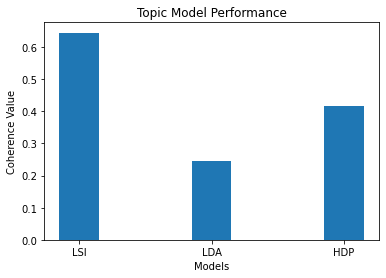

In [40]:
evaluate_bar_graph([lsicoherence, ldacoherence, hdpcoherence], ['LSI', 'LDA', 'HDP'])